# **Utilities DF**

## Expected Features

| features name | type  | description  |
|----	|---	|---
| `building` | str | example description of the feature
| `asset` | str | example description of the feature
| `typology` | str | example description of the feature
| `area` | float | example description of the feature
| `electricity_demmand` | float | example description of the feature
| `water_demmand` | float | example description of the feature

the dataframe is amplified by the specailist dataset: [`ext_seattle`, `ext_nyc`]\
this module should use machine learning models to predict power and water demmand for various building typologies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plot

In [3]:
from etl.extract import ProjectZero

In [4]:
# import projectzero data
from etl.extract import ProjectZero
data = ProjectZero().get_data()

# view keys
data.keys()

# df_model instance
df_model = data['hz_model'].copy()
df_nyc = data['ext_nyc']
df_seattle = data['ext_seattle'].copy()

c:\Users\hramzan\Documents\GitHub\project_zero\etl\extract.py:24: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  for (key, df) in zip(key_names, [pd.read_csv(os.path.join(csv_path, file)) for file in file_names]):


In [52]:
df_seattle.head()

,PrimaryPropertyType,BuildingType,NumberofFloors,PropertyGFATotal,Electricity(kWh),building_classification
0,Hotel,NonResidential,12.0,88434,1080307.0,non_residential
1,Hotel,NonResidential,11.0,103566,1144563.0,non_residential
2,Hotel,NonResidential,41.0,961990,14583930.0,non_residential
3,Hotel,NonResidential,10.0,61320,811521.0,non_residential
4,Hotel,NonResidential,18.0,119890,1777841.0,non_residential


## 1. `get_electricity_demmand`

this method should return a dataframe that has the following features:\
`building`, `area`, `asset`, `electricity_demmand`

In [5]:
df_seattle['PropertyGFABuilding(s)'].unique()

array([ 88434,  88502, 961990, ..., 277566,  48230,  53100], dtype=int64)

In [6]:
# what are the possible crossover columns to train on 
for i in df_seattle.head().columns:
    print(i)

OSEBuildingID
DataYear
BuildingType
PrimaryPropertyType
PropertyName
TaxParcelIdentificationNumber
Location
CouncilDistrictCode
Neighborhood
YearBuilt
NumberofBuildings
NumberofFloors
PropertyGFATotal
PropertyGFAParking
PropertyGFABuilding(s)
ListOfAllPropertyUseTypes
LargestPropertyUseType
LargestPropertyUseTypeGFA
SecondLargestPropertyUseType
SecondLargestPropertyUseTypeGFA
ThirdLargestPropertyUseType
ThirdLargestPropertyUseTypeGFA
YearsENERGYSTARCertified
ENERGYSTARScore
SiteEUI(kBtu/sf)
SiteEUIWN(kBtu/sf)
SourceEUI(kBtu/sf)
SourceEUIWN(kBtu/sf)
SiteEnergyUse(kBtu)
SiteEnergyUseWN(kBtu)
SteamUse(kBtu)
Electricity(kWh)
Electricity(kBtu)
NaturalGas(therms)
NaturalGas(kBtu)
OtherFuelUse(kBtu)
GHGEmissions(MetricTonsCO2e)
GHGEmissionsIntensity(kgCO2e/ft2)
DefaultData
Comment
ComplianceStatus
Outlier
2010 Census Tracts
Seattle Police Department Micro Community Policing Plan Areas
City Council Districts
SPD Beats
Zip Codes


In [7]:
# list of features to use for training
features = ['PrimaryPropertyType','BuildingType','NumberofFloors','PropertyGFATotal','Electricity(kWh)']
df_seattle = df_seattle[features]

In [8]:
df_seattle.shape

(3340, 5)

In [9]:
# check for duplicates
print(df_seattle.duplicated().sum())
df_seattle.drop_duplicates(inplace=True)

print(df_seattle.duplicated().sum())


0
0


In [10]:
# check for missing data
df_seattle.isnull().sum()

PrimaryPropertyType     0
BuildingType            0
NumberofFloors          8
PropertyGFATotal        0
Electricity(kWh)       10
dtype: int64

In [11]:
# change building type to binary value (residential and non resi)
building_type = lambda x: 'residential' if x != 'NonResidential' else 'non_residential'
df_seattle['building_classification'] =  df_seattle['BuildingType'].map(building_type)

df_seattle.building_classification.unique()

array(['non_residential', 'residential'], dtype=object)

In [12]:
df_seattle.isna().sum()

PrimaryPropertyType         0
BuildingType                0
NumberofFloors              8
PropertyGFATotal            0
Electricity(kWh)           10
building_classification     0
dtype: int64

In [13]:
df_seattle.dropna(inplace=True)
df_seattle.NumberofFloors.isna().sum()

df_seattle.describe()

,NumberofFloors,PropertyGFATotal,Electricity(kWh)
count,3322.000000,3.322000e+03,3.322000e+03
mean,4.690247,9.075498e+04,1.016715e+06
std,5.464409,1.494017e+05,2.792036e+06
min,0.000000,2.000000e+04,0.000000e+00
25%,2.000000,2.847050e+04,1.862280e+05
50%,4.000000,4.398350e+04,3.391340e+05
75%,5.000000,8.843200e+04,8.053345e+05
max,99.000000,2.200000e+06,8.344505e+07


### check for correlation and outliers 

) missing from current font.al\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Glyph 13 (
  self._figure.tight_layout(*args, **kwargs)


) missing from current font.al\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from current font.al\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


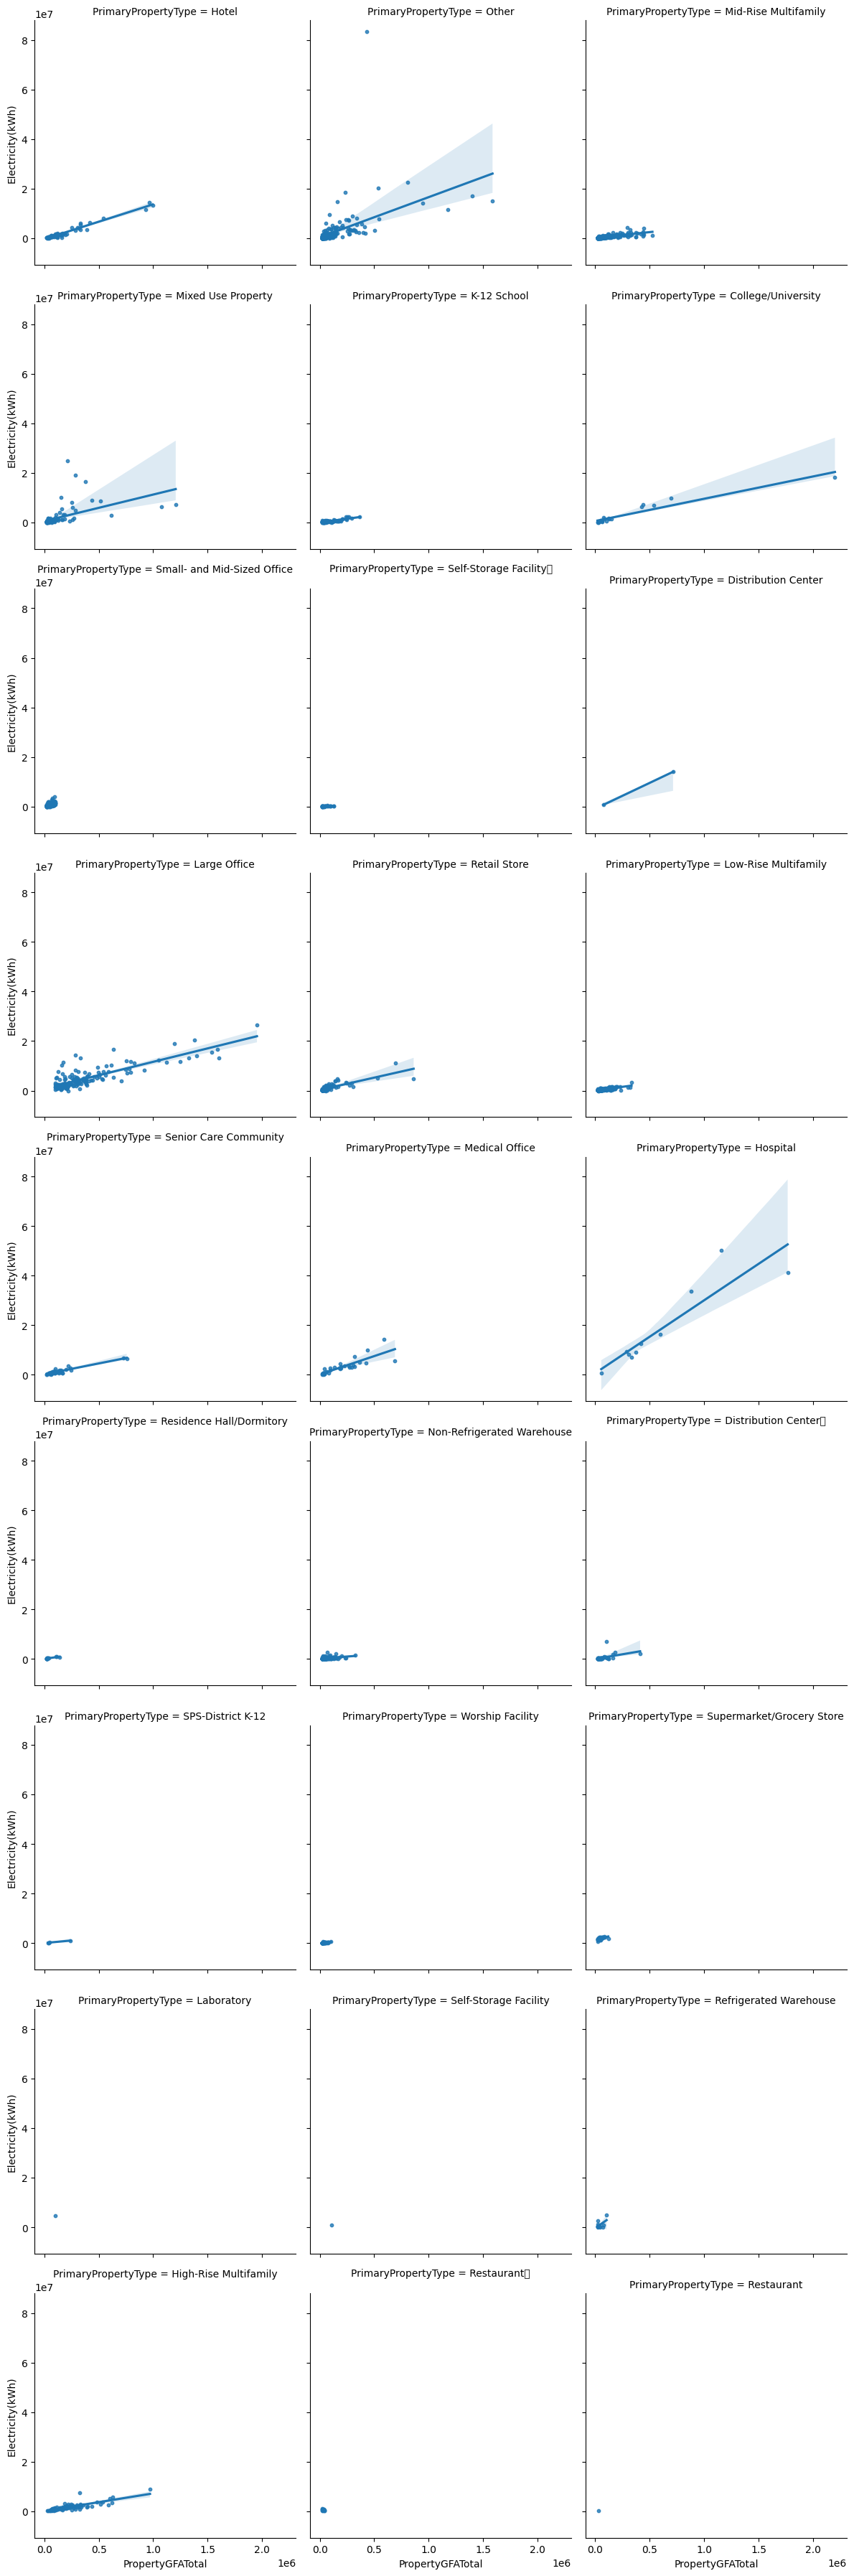

In [14]:
# Regressing GFA to Electricty consumption by property type
g = sns.FacetGrid(data=df_seattle,col='PrimaryPropertyType',col_wrap=3, height=4)
g.map(sns.regplot, 'PropertyGFATotal', 'Electricity(kWh)', scatter_kws={'s': 10})

In [15]:
high_correlation = [
    'Hotel',
    'Low-Rise Multifamily',
    'Mid-Rise Multifamily',
    'High-Rise Multifamily',
    'K-12 School',
    'College/University',
    'Large Office',
    'Retail Store'
    ]

df_seattle = df_seattle[df_seattle.PrimaryPropertyType.isin(high_correlation)] 

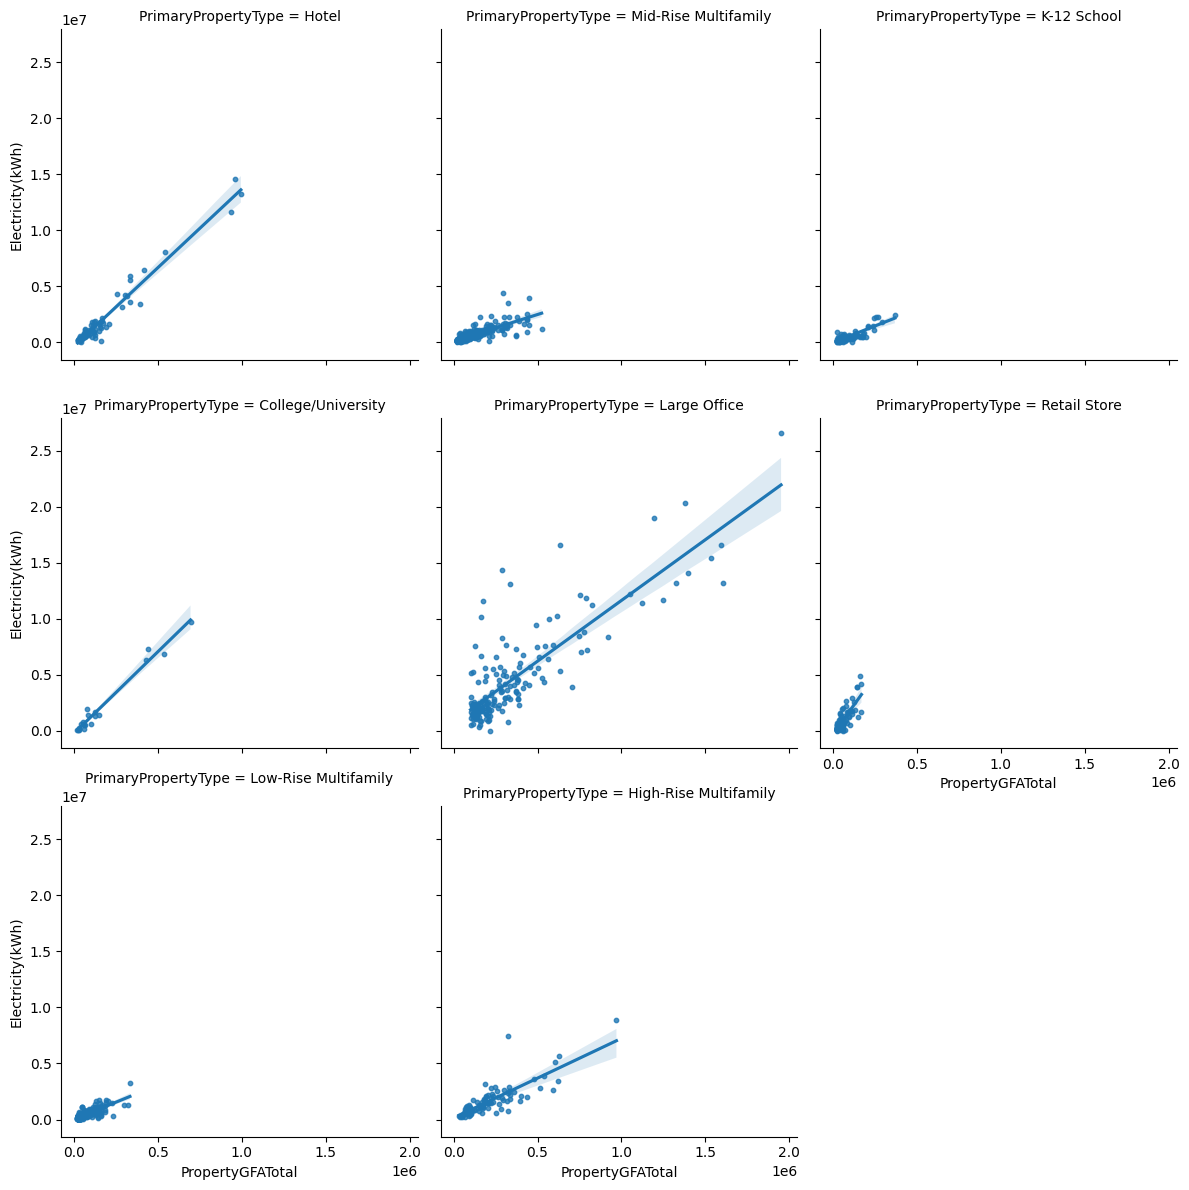

In [26]:
# Regressing GFA to Electricty consumption by filtered property type
g = sns.FacetGrid(data=df_seattle,col='PrimaryPropertyType',col_wrap=3, height=4)
g.map(sns.regplot, 'PropertyGFATotal', 'Electricity(kWh)', scatter_kws={'s': 10})

1952220

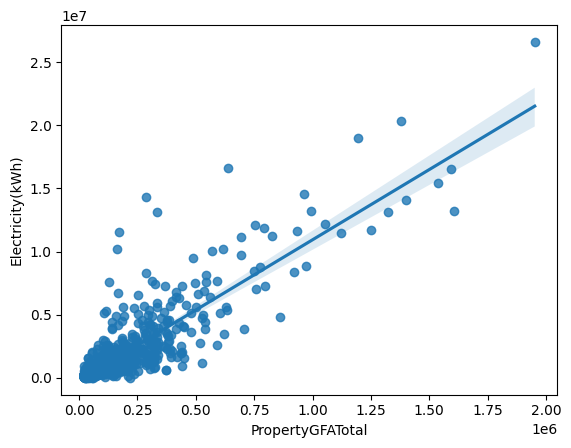

In [17]:
import seaborn as sns

# Filter the DataFrame for 'College/University' property type
df_college_university = df_seattle[df_seattle['PrimaryPropertyType'] == 'College/University']
df_college_university = df_seattle[df_seattle['PropertyGFATotal'] < 2200000]

# Plotting regression between 'Electricity(kWh)' and 'College/University'
sns.regplot(data=df_college_university, x='PropertyGFATotal', y='Electricity(kWh)')

df_college_university.PropertyGFATotal.max()

In [21]:
# Removing outliers for 'College/University' from the original DataFrame
df_seattle = df_seattle[~((df_seattle['PrimaryPropertyType'] == 'College/University') & (df_seattle['PropertyGFATotal'] >= 2200000))]

<Axes: xlabel='PropertyGFATotal', ylabel='Electricity(kWh)'>

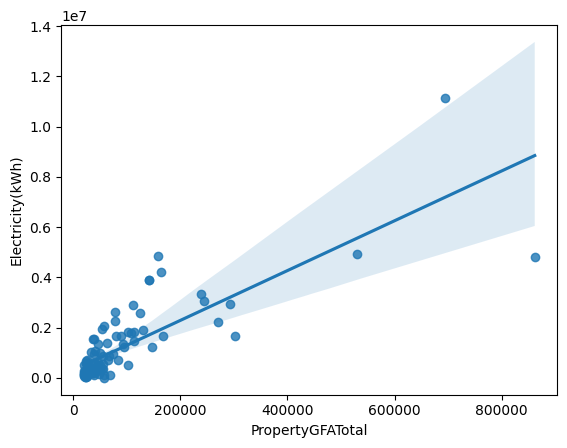

In [23]:
sns.regplot(data=df_seattle[df_seattle.PrimaryPropertyType == 'Retail Store'], x='PropertyGFATotal', y='Electricity(kWh)')

<Axes: xlabel='PropertyGFATotal', ylabel='Electricity(kWh)'>

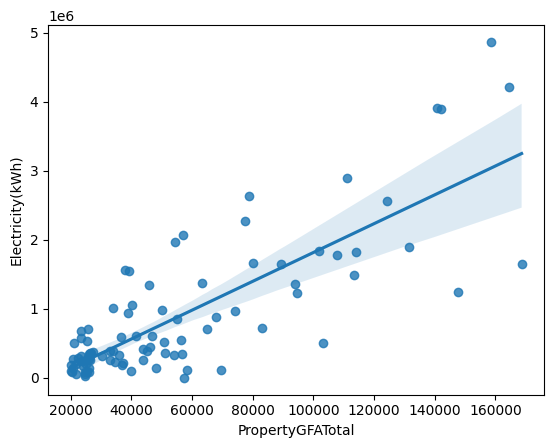

In [27]:
# Removing outliers for 'Retail Store' from the original DataFrame
df_seattle = df_seattle[~((df_seattle['PrimaryPropertyType'] == 'Retail Store') & (df_seattle['PropertyGFATotal'] >= 200000))]

sns.regplot(data=df_seattle[df_seattle.PrimaryPropertyType == 'Retail Store'], x='PropertyGFATotal', y='Electricity(kWh)')

### Scaling the numerical columns

In [33]:
from sklearn.preprocessing import StandardScaler

# instantiate scaler
s_scaler = StandardScaler()

# instantiate scaled df before transform
df_scaled = df_seattle.copy()
numerical_features = ['NumberofFloors','PropertyGFATotal']

# fit scaler
s_scaler.fit(df_seattle[numerical_features])

# apply tranform to features
df_scaled[numerical_features] = s_scaler.transform(df_seattle[numerical_features])

df_scaled

,PrimaryPropertyType,BuildingType,NumberofFloors,PropertyGFATotal,Electricity(kWh),building_classification
0,Hotel,NonResidential,1.067487,-0.044354,1080307.0,non_residential
1,Hotel,NonResidential,0.899623,0.058392,1144563.0,non_residential
2,Hotel,NonResidential,5.935549,5.887067,14583930.0,non_residential
3,Hotel,NonResidential,0.731758,-0.228457,811521.0,non_residential
4,Hotel,NonResidential,2.074672,0.169232,1777841.0,non_residential
...,...,...,...,...,...,...
3335,Low-Rise Multifamily,Multifamily LR (1-4),-0.275427,-0.341646,334979.0,residential
3336,Mid-Rise Multifamily,Multifamily MR (5-9),0.228166,-0.356971,325705.0,residential
3337,High-Rise Multifamily,Multifamily HR (10+),5.767684,1.524449,1690364.0,residential
3338,Low-Rise Multifamily,Multifamily LR (1-4),-0.443291,-0.317338,227744.0,residential


### Encoding descriptive features 🔢

In [37]:
nan_features = ['PrimaryPropertyType','BuildingType','building_classification']

from sklearn.preprocessing import OrdinalEncoder

# Instantiate Ordinal Encoder
ordinal_encoder = OrdinalEncoder()

# Fit to features
ordinal_encoder.fit(df_scaled[nan_features])
display(ordinal_encoder.categories_)

# Transforming categories into ordered numbers
df_scaled[nan_features] = ordinal_encoder.transform(df_scaled[nan_features])

df_scaled

[array([0., 1., 2., 3., 4., 5., 6., 7.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 array([0., 1.])]

,PrimaryPropertyType,BuildingType,NumberofFloors,PropertyGFATotal,Electricity(kWh),building_classification
0,2.0,4.0,1.067487,-0.044354,1080307.0,0.0
1,2.0,4.0,0.899623,0.058392,1144563.0,0.0
2,2.0,4.0,5.935549,5.887067,14583930.0,0.0
3,2.0,4.0,0.731758,-0.228457,811521.0,0.0
4,2.0,4.0,2.074672,0.169232,1777841.0,0.0
...,...,...,...,...,...,...
3335,5.0,2.0,-0.275427,-0.341646,334979.0,1.0
3336,6.0,3.0,0.228166,-0.356971,325705.0,1.0
3337,1.0,1.0,5.767684,1.524449,1690364.0,1.0
3338,5.0,2.0,-0.443291,-0.317338,227744.0,1.0


### Running the model

In [63]:
# import model type
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_validate


# Instantiate model 
sgd_regressor = SGDRegressor()

# define x and y 
features = list(df_scaled.columns)
features.remove('Electricity(kWh)')

X = df_scaled[features]
y = df_scaled['Electricity(kWh)']

# cross validate to test performance
cv_sgd = cross_validate(sgd_regressor, X, y, cv=5)
X

,PrimaryPropertyType,BuildingType,NumberofFloors,PropertyGFATotal,building_classification
0,2.0,4.0,1.067487,-0.044354,0.0
1,2.0,4.0,0.899623,0.058392,0.0
2,2.0,4.0,5.935549,5.887067,0.0
3,2.0,4.0,0.731758,-0.228457,0.0
4,2.0,4.0,2.074672,0.169232,0.0
...,...,...,...,...,...
3335,5.0,2.0,-0.275427,-0.341646,1.0
3336,6.0,3.0,0.228166,-0.356971,1.0
3337,1.0,1.0,5.767684,1.524449,1.0
3338,5.0,2.0,-0.443291,-0.317338,1.0


In [67]:
new_building

,PrimaryPropertyType,BuildingType,NumberofFloors,PropertyGFATotal,building_classification
0,Hotel,NonResidential,12,88434,non_residential


In [66]:
# make first prediction
new_building = pd.DataFrame({
    'PrimaryPropertyType': 'Hotel',
    'BuildingType': 'NonResidential',
    'NumberofFloors': 12,
    'PropertyGFATotal': 88434,
    'building_classification': 'non_residential' 
    }, index=[0])

# train model 
sgd_regressor.fit(X, y)

# scale new prediction values
new_X = pd.DataFrame(s_scaler.transform(new_building))
# new_X.columns = new_building.columns

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- BuildingType
- PrimaryPropertyType
- building_classification


In [54]:
df_seattle.columns

Index(['PrimaryPropertyType', 'BuildingType', 'NumberofFloors',
       'PropertyGFATotal', 'Electricity(kWh)', 'building_classification'],
      dtype='object')

In [55]:
df_seattle.head()

,PrimaryPropertyType,BuildingType,NumberofFloors,PropertyGFATotal,Electricity(kWh),building_classification
0,Hotel,NonResidential,12.0,88434,1080307.0,non_residential
1,Hotel,NonResidential,11.0,103566,1144563.0,non_residential
2,Hotel,NonResidential,41.0,961990,14583930.0,non_residential
3,Hotel,NonResidential,10.0,61320,811521.0,non_residential
4,Hotel,NonResidential,18.0,119890,1777841.0,non_residential


`dont forget to convert gfa units to m2`

## 2. `get_water_demmand`

this method should return a dataframe that has the following features:\
`building`, `area`, `asset`, `potable_water_demmand`

In [19]:
df_model.isna().sum()

ID          0
Typology    0
Area        0
Plot        0
Building    0
Colour      0
dtype: int64